# Analysis of Urban-Traffic Simulated Data – part I
##### Ruggero Fabbiano – 24 November 2020

## Summary

With this notebook we start the exploration of a set of urban-traffic data obtained via the [SUMo simulator](https://www.eclipse.org/sumo/), an open-source microscopic traffic simulator that can take representations of real-world cities as input scenarios and can produce a variety of output data (vehicle state, road state, pollution information, etc.).

Here below we provide, for ease of comprehension, a brief summary of the scenario used and the output data generated, as well as the objectives of this first exploratory analysis.

#### Scenario
The scenario used for this simulation is the [**MoST** (_Monaco SUMo traffic_) scenario](https://github.com/lcodeca/MoSTScenario), which models the agglomeration area of the Principality of Monaco, covering an area of about 70 km² (greater area) and spanning from 4 AM to 2 PM.

Its first implementation showed a morning congestion towards the city modeled via a Gaussian vehicle demand of 20,000 objects, with average at 8:15 AM and standard deviation equal to 90'. <font color="blue">We have simulations spanning several time intervals, however the one used throughout this notebook covers time from 4 AM to 6 AM.</font> Also, we made the choice to set a time step equal to 1 s, and saving the output each 5 s.

#### Output
Among the possibilities SUMo offers for data generation, we chose the FCD (_floating car data_) output, which is focused on the vehicle information. To help you better understand the analysis that follow, here below a resume of the data that the floating-car output generates:

* `timestep_time` [s] – the current simulation time (0 corresponds to the beginning of the day)
* `vehicle_id` / `person_id` – a unique object identifier
* `vehicle_angle` / `person_angle` [°] – orientation of the object in navigational standard (0-360°)
* `vehicle_lane` – the ID of the lane the vehicle is currently moving onto
* `vehicle_pos` / `person_pos` [m] – running position of the object from the start of the current lane
* `vehicle_slope` / `person_slope` [°] – slope of the object lane at object position
* `vehicle_speed` / `person_speed` [m/s] – absolute speed of the object
* `vehicle_type` – the type of the vehicle (private vehicle, Uber, delivery truck etc.)
* `vehicle_x` / `person_x` [m] – absolute _x_ coordinate / longitude of the object
* `vehicle_y` / `person_y` [m] – absolute _y_ coordinate / latitude of the object
* `vehicle_z` / `person_z` [m] – elevation of the object
* `person_edge` – edge the virtual footpath where the person is moving on is connected to

### Goal
The first part of the analysis focuses on checking if we can reduce the sparsity of the dataset, thus having to handle a lighter and more compact dataframe. Then, we start by investigating if the MoST properties described in the [2018 MoST article] (https://easychair.org/publications/download/x3nd) still hold true. <font color="blue">A deeper analysis will be the object of a following notebook.</font>

 ***

## Import Packages and Data

Let's be sure we have all the necessary packages installed:

In [3]:
!pip install pandas --upgrade
!pip install datetime
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install wget

We can now import them:

In [168]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('bmh')

Now to the data.

Let's define the local path to the CSV file, as well as the remote one; we will then be able to load the local file if present, or download it otherwise.

In [169]:
out_file = 'most_0400_0600_1_5.csv'
local_fp = './' + out_file
remote_fp = 'https://standard-traffic-data.s3.us-east-2.amazonaws.com/' + out_file

In [170]:
!wget -nc $remote_fp -O $local_fp

File './most_0400_0600_1_5.csv' already there; not retrieving.


In [171]:
data = pd.read_csv(out_file, sep=';', low_memory=False)
data.info()
mem_original = data.memory_usage().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067350 entries, 0 to 2067349
Data columns (total 20 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestep_time  float64
 1   vehicle_angle  float64
 2   vehicle_id     object 
 3   vehicle_lane   object 
 4   vehicle_pos    float64
 5   vehicle_slope  float64
 6   vehicle_speed  float64
 7   vehicle_type   object 
 8   vehicle_x      float64
 9   vehicle_y      float64
 10  vehicle_z      float64
 11  person_angle   float64
 12  person_edge    object 
 13  person_id      object 
 14  person_pos     float64
 15  person_slope   float64
 16  person_speed   float64
 17  person_x       float64
 18  person_y       float64
 19  person_z       float64
dtypes: float64(15), object(5)
memory usage: 315.5+ MB


We now have our dataset ready.
In the next section we're going to see if we can reduce its memory usage without information loss.

## Data cleaning

### Drop empty rows

Let's start by doing a sanity check over the timestep feature (that should always be not null):

In [172]:
assert data.shape == data.dropna(how='all').shape

We can now drop all the rows with no active object (i.e., with the timestep being the only not null value).
Before doing so, let's extract some relevant time steps that can be useful in our further analysis:

In [173]:
t_s = data['timestep_time'].iloc[0] # first timestep
t_e = data['timestep_time'].iloc[-1] # last timestep

i_first = data[['vehicle_id', 'person_id']].first_valid_index()
t_o = data['timestep_time'].iloc[i_first] # first timestep with an object

We're now ready to drop the empty rows:

In [174]:
data.drop(data.index[:i_first], inplace=True)
data.reset_index(drop=True, inplace=True)

### Feature cleaning

We can now focus on the features. If we look back at the feature names it looks like some of them are repeated twice, both for persons and vehicles. We can probably merge them to reduce the size of the dataset.

Before doing that, we need to be sure that the information is divided into the couple of features, so that we won't lose any data.

The suspects seem to be `angle`, `id`, `pos`, `slope`, `speed`, `x`, `y`, and `z`. Let's check them:

In [175]:
features = ['angle', 'id', 'pos', 'slope', 'speed', 'x', 'y', 'z']
mergeable_features = [f for f in features if
                      np.where((data['vehicle_'+f].notna()) & (data['person_'+f].notna()), False, True).any()]

mergeable_features

['angle', 'id', 'pos', 'slope', 'speed', 'x', 'y', 'z']

The vector obtained above tells us which features have information split between the two columns of the couple; in such case we can safely merge them without losing any information. 

In [176]:
for f in mergeable_features:
    data['vehicle_'+f].fillna(data['person_'+f], inplace=True)
    data.drop('person_'+f, axis='columns', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067349 entries, 0 to 2067348
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestep_time  float64
 1   vehicle_angle  float64
 2   vehicle_id     object 
 3   vehicle_lane   object 
 4   vehicle_pos    float64
 5   vehicle_slope  float64
 6   vehicle_speed  float64
 7   vehicle_type   object 
 8   vehicle_x      float64
 9   vehicle_y      float64
 10  vehicle_z      float64
 11  person_edge    object 
dtypes: float64(8), object(4)
memory usage: 189.3+ MB


Also `vehicle_lane` and `person_edge` seem to carry the same information (where in the network the object currently is); let's repeat the process for this couple of features:

In [177]:
if np.where((data['vehicle_lane'].notna()) & (data['person_edge'].notna()), False, True).any():
    data['vehicle_lane'].fillna(data['person_edge'], inplace=True)
    data.drop('person_edge', axis='columns', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067349 entries, 0 to 2067348
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestep_time  float64
 1   vehicle_angle  float64
 2   vehicle_id     object 
 3   vehicle_lane   object 
 4   vehicle_pos    float64
 5   vehicle_slope  float64
 6   vehicle_speed  float64
 7   vehicle_type   object 
 8   vehicle_x      float64
 9   vehicle_y      float64
 10  vehicle_z      float64
dtypes: float64(8), object(3)
memory usage: 173.5+ MB


We can now rename the features to make them more understandeable (the `vehicle` prefix does not make any sense anymore), and take a look at our more compact dataframe:

In [178]:
data.rename(columns={'timestep_time': "t", 'vehicle_angle': "angle", 'vehicle_id': "ID", 'vehicle_pos': "position",
                     'vehicle_slope': "slope", 'vehicle_speed': "speed", 'vehicle_x': "x", 'vehicle_y': "y",
                     'vehicle_z': "z", 'vehicle_lane': "lane_edge", 'vehicle_type': "v_type", }, inplace=True)
data.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z
0,14405.0,80.89,bus_M1:France.0,152927_1,12.10,3.01,0.00,bus,1085.69,197.96,54.34
1,14410.0,71.94,bus_M1:France.0,152927_1,23.63,1.31,3.97,bus,1096.59,201.56,54.75
2,14415.0,57.57,bus_M1:France.0,152927_1,57.99,0.66,8.49,bus,1126.83,217.57,55.32
3,14420.0,32.10,bus_M1:France.0,152927_1,113.32,0.63,12.78,bus,1167.22,253.89,55.41
4,14425.0,53.85,bus_M1:Eze.0,-153460_1,18.12,1.73,3.09,bus,44.23,1368.97,358.63


We have our dataframe ready to be analysed.
Before, let's check the amount of memory we saved, to see if all this process made sense:

In [179]:
data.info()
mem_after = data.memory_usage().sum()
print(F"{1-mem_after/mem_original:.2%} less than the original data-frame")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067349 entries, 0 to 2067348
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   t          float64
 1   angle      float64
 2   ID         object 
 3   lane_edge  object 
 4   position   float64
 5   slope      float64
 6   speed      float64
 7   v_type     object 
 8   x          float64
 9   y          float64
 10  z          float64
dtypes: float64(8), object(3)
memory usage: 173.5+ MB
45.00% less than the original data-frame


Wow, we reduced the memory of almost a half, definitely worth it.

## Exploratory Data Analysis

Let's verify the starting and ending time of the simulation, and when the first vehicle (or person) appears:

In [180]:
def t_format(timestep):
    return str(datetime.timedelta(seconds=timestep))

In [181]:
print("Data time interval:", t_format(t_s), "–", t_format(t_e))
print("First object appears at", t_format(t_o))

Data time interval: 4:00:00 – 5:59:55
First object appears at 4:00:05


Let's see now how many objects are active for each time step; if the traffic distribution still holds normal centered at 8:15 AM and with standard deviation equal to 90', we would expect them to be substantially increasing since around 5 AM.

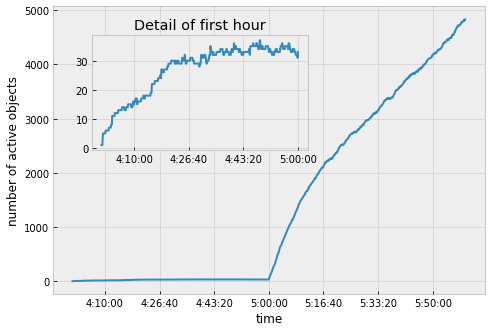

In [182]:
obj_num_by_t = data.groupby(['t']).count()['ID']

fig = plt.figure()

ax1 = fig.add_axes([0, 0, 1, 1])
ax1.plot(obj_num_by_t)
# ax.set_title('Active objects')
ax1.set_xlabel("time")
ax1.set_ylabel("number of active objects")
ax1.set_xticklabels(t_format(tick) for tick in ax1.get_xticks());

ax2 = fig.add_axes([0.09, 0.5, 0.5, 0.4])
ax2.plot(obj_num_by_t[t_s:t_s+3601])
ax2.set_title("Detail of first hour")
ax2.set_xticklabels(t_format(tick) for tick in ax2.get_xticks());

Let's focus now on the life time of the objects in the simulation; given the size of the area, we expect a time spanning from a few minutes to probably less than an hour.

In [183]:
ID_per_t = data.groupby('ID').count()['t']
Delta = np.diff(data['t'].unique())[0]

labels = ["Min.", "Average", "Max."]
values = [ID_per_t.min(), ID_per_t.mean(), ID_per_t.max()]

for l,v in zip(labels, values):
    print(l, F"life time: {int((v-1)*Delta/60)} m {int((v-1)*Delta % 60)} s")

Min. life time: 0 m 0 s
Average life time: 14 m 17 s
Max. life time: 59 m 50 s


Weird, it looks like some objects only appear in the simulation for one time step:

In [184]:
ID_per_t[ID_per_t==ID_per_t.min()]

ID
pedestrian_1-1-pt_3865       1
pedestrian_1-1-pt_3865_tr    1
pedestrian_1-1-pt_4564       1
pedestrian_1-1-pt_4564_tr    1
pedestrian_1-1-pt_7931       1
pedestrian_1-1-pt_7931_tr    1
pedestrian_1-1-pt_821        1
pedestrian_1-1-pt_821_tr     1
pedestrian_1-1-veh_522       1
pedestrian_1-1-veh_522_tr    1
pedestrian_1-2_3             1
pedestrian_1-2_3_tr          1
pedestrian_1-3_1755          1
pedestrian_1-3_1755_tr       1
pedestrian_1-GW1_2157        1
pedestrian_1-GW1_2157_tr     1
pedestrian_1-GW2_963         1
pedestrian_1-GW2_963_tr      1
pedestrian_GW1-1_2022        1
pedestrian_GW1-1_2022_tr     1
Name: t, dtype: int64

Probably a bug of the model, or some borderline behaviour. To get an idea of the issue, let's verify the total number of objects in the simulation (given the spanning time and the demand distributions, we should have not more than 10 % of the supposed 20 thousands vehicles overall):

In [185]:
p = len(data['ID'][data['v_type'].isna()].unique())
v = len(data['ID'][data['v_type'].notna()].unique())

print(F"{p+v} objects in the simulations, divided into {p} pedestrians and {v} vehicles of any type")

# sanity check
assert p+v == len(data['ID'].unique())

11991 objects in the simulations, divided into 5843 pedestrians and 6148 vehicles of any type


They are even more than expected (20 thousands overall in the first MoST version). Let's check the percentage of objects with a life time shorter than 1 minute:

In [186]:
ghost_objects = ID_per_t[ID_per_t<60/Delta]
ghost_percent = ghost_objects.count()/len(data['ID'].unique())*100

print(F"{ghost_percent:.2F} % of data objects lives less than 1 minute")

2.16 % of data objects lives less than 1 minute


A bit more than 2 %; we can drop them:

In [187]:
data = data[~data['ID'].isin(ghost_objects.index)]

Let's take a look now at the object demand by time:

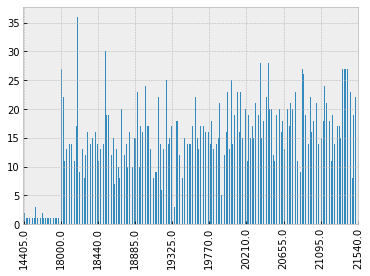

In [188]:
new_obj_per_time = data.groupby('ID')['t'].min().value_counts().sort_index()

tick_pos = np.linspace(0, len(new_obj_per_time)-1, 10, dtype=int)

ax = new_obj_per_time.plot.bar(xticks=tick_pos)

# ax.set_xticklabels([t_format(t) for t in new_obj_per_time.index[tick_pos]]); temporary, to compare with line plot
ax.set_xticklabels(new_obj_per_time.index[tick_pos]);

...And at the cumulative demand:

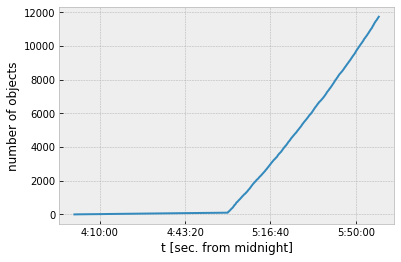

In [189]:
cumulated = new_obj_per_time.cumsum()

ax = cumulated.plot(xlabel='t [sec. from midnight]', ylabel='number of objects')

x_ticks = ax.get_xticks()[1:-1:2]
ax.set_xticks(x_ticks)
ax.set_xticklabels([t_format(t) for t in x_ticks]);

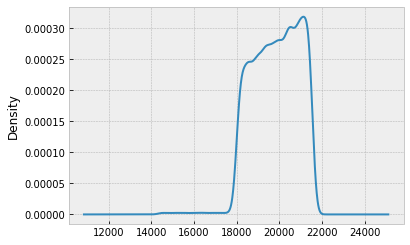

In [258]:
# kernel density estimation
time_values = []
for t,n in new_obj_per_time.items():
    time_values.extend([t]*n)
pd.Series(time_values).plot.kde()

# TEST

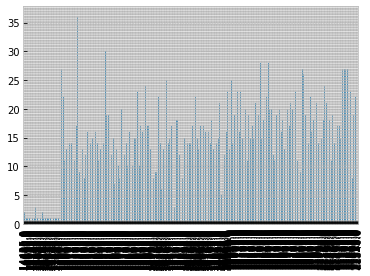

In [239]:
new_obj_per_time.plot.bar()

In [240]:
new_obj_per_time[new_obj_per_time==new_obj_per_time.max()]
# we should have 3 bars over 35!

18200.0    36
19740.0    36
21000.0    36
Name: t, dtype: int64

### Bar-plot in batches

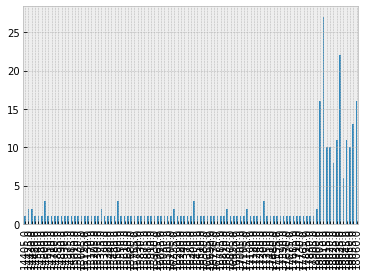

In [241]:
new_obj_per_time.iloc[:101].plot.bar()

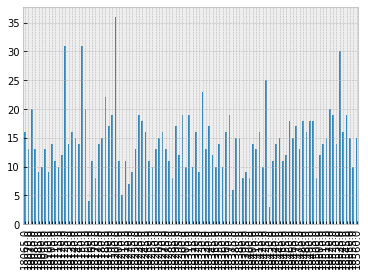

In [242]:
new_obj_per_time.iloc[101:201].plot.bar() # first one comes

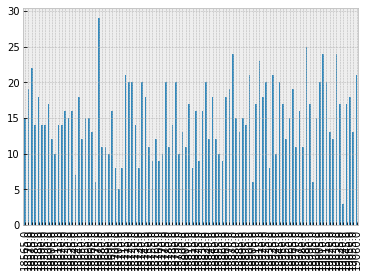

In [243]:
new_obj_per_time.iloc[201:301].plot.bar()

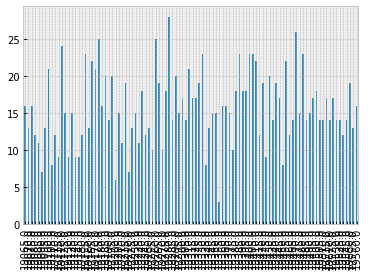

In [244]:
new_obj_per_time.iloc[301:401].plot.bar()

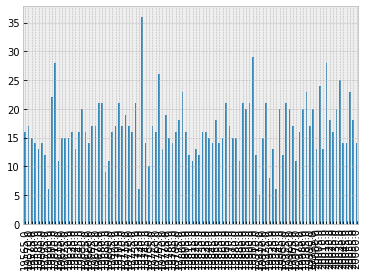

In [245]:
new_obj_per_time.iloc[401:501].plot.bar() # here the second!

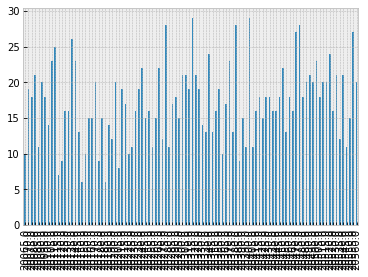

In [246]:
new_obj_per_time.iloc[501:601].plot.bar()

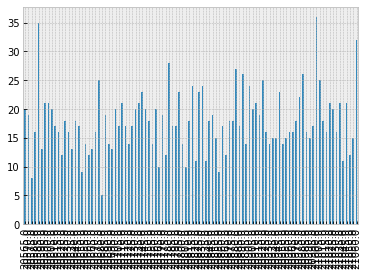

In [247]:
new_obj_per_time.iloc[601:701].plot.bar() # here the third...

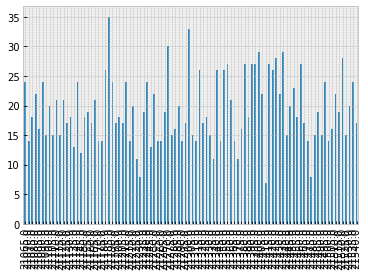

In [248]:
new_obj_per_time.iloc[701:].plot.bar()